### BERT Embeddings

In [1]:
import pandas as pd
import torch
from transformers import BertForMaskedLM
from src.preprocessing import preprocess_df, random_train_test_split, TextEncoder, set_labels_features
from src.tokenizers import CustomBertTokenizer
from src.dataset import LabValuesDataset
from src.train import train_mlm
from src.embeddings import load_model, get_embeddings
import numpy as np
import matplotlib.pyplot as plt

/home/opc/anaconda3/envs/labrador/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Constants

FILE = 'data/morning_lab_values.csv'
COLUMNS = ['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']
BINS = 10

MASKING = 0.20

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('mps') if torch.cuda.is_available() else torch.device('cpu') # Apple slilicon


### Read dataset

In [3]:
df = pd.read_csv(FILE)

In [4]:
df.head()

,hadm_id,subject_id,itemid,charttime,charthour,storetime,storehour,chartday,valuenum,cnt
0,NaN,10312413,51222,2173-06-05 08:20:00,8,2173-06-05 08:47:00,8,2173-06-05,12.8,8
1,25669789.0,10390828,51222,2181-10-26 07:55:00,7,2181-10-26 08:46:00,8,2181-10-26,9.4,8
2,26646522.0,10447634,51222,2165-03-07 06:55:00,6,2165-03-07 07:23:00,7,2165-03-07,11.1,8
3,27308928.0,10784877,51222,2170-05-11 06:00:00,6,2170-05-11 06:43:00,6,2170-05-11,10.3,8
4,28740988.0,11298819,51222,2142-09-13 07:15:00,7,2142-09-13 09:23:00,9,2142-09-13,10.2,8


### Preprocessing

In [5]:
mrl = preprocess_df(df, scaler='log', columns_to_scale=COLUMNS, num_bins=BINS)

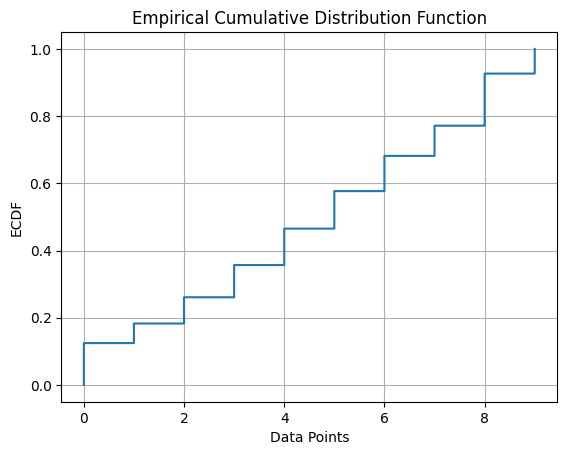

In [6]:
# Compute the empirical distribution function
def compute_edf(data):
    """ compute the empirical distribution function for a 1D array of measurements"""

    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n

    return x, y


x, y = compute_edf(mrl['Bic'])

# Plotting the EDF
plt.step(x, y, where="post")
plt.xlabel('Data Points')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function')
plt.grid(True)
plt.show()

In [7]:
text_encoder = TextEncoder(bins=BINS)
mrl, grouped_mrl = text_encoder.encode_text(mrl)

In [8]:
grouped_mrl

,hadm_id,nstr
0,20000019.0,[Bic BicD Crt CrtE Pot PotA Sod SodD Ure UreF ...
1,20000024.0,[Bic BicE Crt CrtE Pot PotJ Sod SodG Ure UreH ...
2,20000034.0,[Bic BicD Crt CrtI Pot PotJ Sod SodH Ure UreH ...
3,20000041.0,[Bic BicF Crt CrtE Pot PotD Sod SodC Ure UreE ...
4,20000057.0,[Bic BicA Crt CrtE Pot PotG Sod SodD Ure UreF ...
...,...,...
264582,29999625.0,[Bic BicG Crt CrtC Pot PotJ Sod SodJ Ure UreI ...
264583,29999670.0,[Bic BicG Crt CrtG Pot PotF Sod SodI Ure UreH ...
264584,29999723.0,[Bic BicH Crt CrtD Pot PotD Sod SodH Ure UreG ...
264585,29999745.0,[Bic BicI Crt CrtC Pot PotF Sod SodJ Ure UreC ...


### Tokenize

In [9]:
vocab_list = mrl['nstr'].str.split(' ').explode().unique().tolist()

# Set special tokens:
# if length of vocab_list is less than 100, then use the default special tokens
if len(vocab_list) < 100:
    special_tokens = {0: '[PAD]', len(vocab_list)+1: '[CLS]', len(vocab_list)+2: '[SEP]', len(vocab_list)+3: '[MASK]'}
else:
    special_tokens = {0: '[PAD]', 101: '[CLS]', 102: '[SEP]', 103: '[MASK]'}
    
special_tokens_positions = {value: key for key, value in special_tokens.items()}

tokenizer = CustomBertTokenizer.create_bert_tokenizer(vocab_list, special_tokens=special_tokens)

In [10]:
text = grouped_mrl['nstr'].apply(lambda x: ' [SEP] '.join(x)).tolist()
train, test = random_train_test_split(text)

In [11]:
train_inputs = tokenizer(train, return_tensors='pt', max_length=100, truncation=True, padding='max_length')

test_inputs = tokenizer(test, return_tensors='pt', max_length=100, truncation=True, padding='max_length')

### Dataset Perparation

In [12]:
train_inputs, test_inputs = set_labels_features(train_inputs, test_inputs, parcentage=MASKING, CLS=special_tokens_positions['[CLS]'], SEP=special_tokens_positions['[SEP]'], PAD=0, MASK=special_tokens_positions['[MASK]'])

In [13]:
train_dataset = LabValuesDataset(train_inputs)
test_dataset = LabValuesDataset(test_inputs)

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=1)

### Model

In [15]:
from torch import nn

model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.resize_token_embeddings(len(tokenizer))
# and move our model over to the selected device
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    #model = nn.DataParallel(model, [0,1])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using 2 GPUs!


### Training

/home/opc/anaconda3/envs/labrador/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/13230 [00:00<?, ?it/s]/home/opc/Labrador/src/dataset.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
  0%|          | 0/3308 [00:00<?, ?it/s]/home/opc/Labrador/src/dataset.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for 

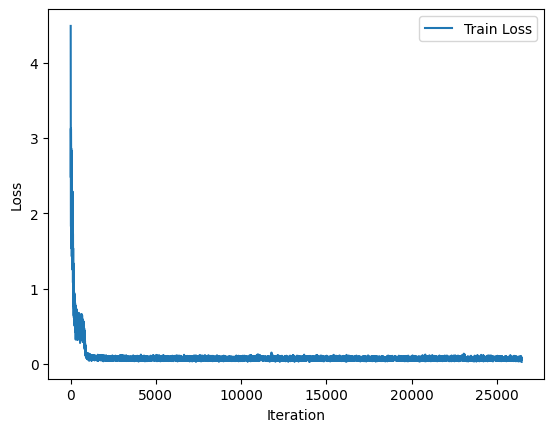

In [16]:
train_mlm(model, train_loader, test_loader, device, tokenizer)

### Load model

In [17]:
model, tokenizer = load_model(model_path="model/", tokenizer_path="tokenizer/")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'CustomBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


### Generate embeddings

In [18]:
texts_to_embed = ["BicAS CrtC PotR SodBI UreG HgbAQ PltH WbcB", "BicBD CrtB PotX SodBP UreE HgbBM PltJ WbcA"]

embeddings = get_embeddings(model, tokenizer, texts_to_embed)
print("Embeddings Shape:", embeddings.shape)
print(embeddings)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Embeddings Shape: (2, 10, 768)
[[[-0.84424376  0.54832876 -0.14583153 ... -0.5394765  -0.9306911
   -0.73395956]
  [-0.181278    0.4734843   0.31911683 ...  0.17626072 -0.47134942
   -0.7615029 ]
  [-0.20101662  0.6967074  -0.08911975 ... -0.3098796  -0.3722264
    0.36841875]
  ...
  [-0.46719772  0.73551023  0.48717424 ... -0.59683335  0.50769526
    1.1487736 ]
  [-0.9078782  -0.58773905  0.3690474  ...  0.559175    0.21782438
    0.40296134]
  [ 0.24518748 -0.34714988  0.12307081 ...  0.02087363  0.04780937
    0.40536457]]

 [[-0.7321815   0.5181698  -0.22612736 ... -0.39692315 -1.1696469
   -0.7697059 ]
  [ 0.01314184  0.6386283   0.33756775 ...  0.18644677 -0.5483326
   -0.82196903]
  [ 0.18762569 -0.27669445 -0.50159556 ... -0.48492327  0.18653208
    0.62502444]
  ...
  [-0.84507114  0.97770935  0.5248242  ... -0.2114231   0.29276994
    1.1973405 ]
  [-0.8899526  -0.12650405  0.11929252 ...  0.88871443 -1.1402302
   -0.60822016]
  [ 0.2920875  -0.288081    0.11325388 ...  0.0